In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests
from bs4 import BeautifulSoup
from PIL import Image
from colormap import rgb2hex
import cv2
from scipy import cluster
from sklearn.preprocessing import MinMaxScaler
import imagesize
import random
from sklearn.preprocessing import LabelEncoder
from ipywidgets import interact
import time
from io import BytesIO


# Attribute cleaning

In [2]:
PATH = 'data/DeepFashion_categorical_images_low/'

In [3]:
cat_names = pd.read_csv('Data/DeepFashion_attributes - train/list_category.txt',sep ='\s+',header=None).reset_index().rename(columns={0:'category',1:'category_type','index':'cat_num'})



In [4]:
cat_names['cat_num'] = cat_names['cat_num'].apply(lambda x : x+1)

In [5]:
cat_names.head()

,cat_num,category,category_type
0,1,Anorak,1
1,2,Blazer,1
2,3,Blouse,1
3,4,Bomber,1
4,5,Button-Down,1


In [6]:
cat_num = pd.read_csv('Data/DeepFashion_attributes - train/cat.txt',sep='\s+',header=None,names=['category']).reset_index().rename(columns={'category':'cat_num','index':'img'})



In [7]:
cat_num[['img']] = cat_num[['img']].applymap(lambda x: x[4:])

In [8]:
cat_num.head()

,img,cat_num
0,Sheer_Pleated-Front_Blouse/img_00000001.jpg,3
1,Sheer_Pleated-Front_Blouse/img_00000002.jpg,3
2,Sheer_Pleated-Front_Blouse/img_00000003.jpg,3
3,Sheer_Pleated-Front_Blouse/img_00000004.jpg,3
4,Sheer_Pleated-Front_Blouse/img_00000005.jpg,3


In [67]:
cat = cat_num.merge(cat_names, on='cat_num', how='left').drop(columns='cat_num').set_index('img')



In [68]:
cat

,category,category_type
img,,
Sheer_Pleated-Front_Blouse/img_00000001.jpg,Blouse,1
Sheer_Pleated-Front_Blouse/img_00000002.jpg,Blouse,1
Sheer_Pleated-Front_Blouse/img_00000003.jpg,Blouse,1
Sheer_Pleated-Front_Blouse/img_00000004.jpg,Blouse,1
Sheer_Pleated-Front_Blouse/img_00000005.jpg,Blouse,1
...,...,...
Paisley_Print_Babydoll_Dress/img_00000050.jpg,Dress,3
Paisley_Print_Babydoll_Dress/img_00000051.jpg,Dress,3
Paisley_Print_Babydoll_Dress/img_00000052.jpg,Dress,3


In [69]:
cat['category_type'] = cat['category_type'].map({1:'upper',2:'lower',3:'full body'})

In [12]:
attr_names = pd.read_csv('Data/DeepFashion_attributes - train/list_attr_simple.txt',sep='\s+', header=None).rename(columns={0:'attribute',1:'attribute type'})


In [13]:
attr_names

,attribute,attribute type
0,floral,1
1,graphic,1
2,striped,1
3,embroidered,1
4,pleated,1
5,solid,1
6,lattice,1
7,long_sleeve,2
8,short_sleeve,2
9,sleeveless,2


In [14]:
attr_names['attribute type'] = attr_names['attribute type'].map({1:'design',2:'sleeves',3:'length',4:'part',5:'fabric',6:'fit'})


In [15]:
attr_names

,attribute,attribute type
0,floral,design
1,graphic,design
2,striped,design
3,embroidered,design
4,pleated,design
5,solid,design
6,lattice,design
7,long_sleeve,sleeves
8,short_sleeve,sleeves
9,sleeveless,sleeves


In [16]:
attr_names_headers = attr_names.iloc[:,0]
attr_names_headers

0              floral
1             graphic
2             striped
3         embroidered
4             pleated
5               solid
6             lattice
7         long_sleeve
8        short_sleeve
9          sleeveless
10        maxi_length
11        mini_length
12           no_dress
13      crew_neckline
14         v_neckline
15    square_neckline
16        no_neckline
17              denim
18            chiffon
19             cotton
20            leather
21               faux
22               knit
23              tight
24              loose
25       conventional
Name: attribute, dtype: object

In [86]:
attr_tags = pd.read_csv('Data/DeepFashion_attributes - train/tags_attr_simple.txt',sep='\s+',header=None,names=attr_names_headers)


In [87]:
attr_tags

,floral,graphic,striped,embroidered,pleated,solid,lattice,long_sleeve,short_sleeve,sleeveless,maxi_length,mini_length,no_dress,crew_neckline,v_neckline,square_neckline,no_neckline,denim,chiffon,cotton,leather,faux,knit,tight,loose,conventional
0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1
19996,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
19997,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1
19998,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1


In [90]:
attr_img = pd.read_csv('Data/DeepFashion_attributes - train/img_attr_simple.txt',sep='\s+',header=None).rename(columns={0:'img'})



In [91]:
attr_img

,img
0,img/Sweet_Crochet_Blouse/img_00000070.jpg
1,img/Classic_Pencil_Skirt/img_00000010.jpg
2,img/Strapless_Diamond_Print_Dress/img_00000038...
3,img/Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_0000...
4,img/Zippered_Single-Button_Blazer/img_00000078...
...,...
19995,img/Embroidered_Peasant_Tank/img_00000044.jpg
19996,img/Tasmanian_Devil_Sweater/img_00000048.jpg
19997,img/Lace-Sleeved_Raglan_Henley/img_00000022.jpg
19998,img/Floral_Mosaic_Print_Jumpsuit/img_00000017.jpg


In [94]:
attr = attr_img.join(attr_tags,how='inner')

In [104]:
attr = attr.drop(columns='t')

In [99]:
attr['img'] = attr['img'].apply(lambda x: x[4:])

In [100]:
attr

,img,floral,graphic,striped,embroidered,pleated,solid,lattice,long_sleeve,short_sleeve,sleeveless,maxi_length,mini_length,no_dress,crew_neckline,v_neckline,square_neckline,no_neckline,denim,chiffon,cotton,leather,faux,knit,tight,loose,conventional,t
0,Sweet_Crochet_Blouse/img_00000070.jpg,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,Sweet_Crochet_Blouse/img_00000070.jpg
1,Classic_Pencil_Skirt/img_00000010.jpg,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,Classic_Pencil_Skirt/img_00000010.jpg
2,Strapless_Diamond_Print_Dress/img_00000038.jpg,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,Strapless_Diamond_Print_Dress/img_00000038.jpg
3,Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010...,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010...
4,Zippered_Single-Button_Blazer/img_00000078.jpg,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,Zippered_Single-Button_Blazer/img_00000078.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Embroidered_Peasant_Tank/img_00000044.jpg,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,Embroidered_Peasant_Tank/img_00000044.jpg
19996,Tasmanian_Devil_Sweater/img_00000048.jpg,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,Tasmanian_Devil_Sweater/img_00000048.jpg
19997,Lace-Sleeved_Raglan_Henley/img_00000022.jpg,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,Lace-Sleeved_Raglan_Henley/img_00000022.jpg
19998,Floral_Mosaic_Print_Jumpsuit/img_00000017.jpg,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,Floral_Mosaic_Print_Jumpsuit/img_00000017.jpg


In [73]:
attr['img'] = attr['img'].apply(lambda x: x.replace('-','/'))

In [38]:
bb = pd.read_csv('Data/DeepFashion_attributes - train/bbox.txt',sep='\s+',header=None,index_col=False, names=['img','x_1', 'y_1', 'x_2', 'y_2'])


In [39]:
bb['img'] = bb['img'].apply(lambda x: x[4:])

In [40]:
bb.set_index('img',inplace=True)

In [41]:
bb

,x_1,y_1,x_2,y_2
img,,,,
Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273
Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161
Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200
Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182
Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262
...,...,...,...,...
Paisley_Print_Babydoll_Dress/img_00000050.jpg,1,1,300,300
Paisley_Print_Babydoll_Dress/img_00000051.jpg,14,58,225,277
Paisley_Print_Babydoll_Dress/img_00000052.jpg,18,41,149,230


In [42]:
pd.set_option('display.max_columns', None)

In [43]:
landmarks = pd.read_csv('Data/DeepFashion_attributes - train/landmarks.txt',sep='\s+',names=['img','clothes_type','v1','x1','y1','v2','x2','y2','v3','x3','y3','v4','x4','y4','v5','x5','y5','v6','x6','y6','v7','x7','y7','v8','x8','y8']).fillna(0).drop(columns=['clothes_type'])


In [44]:
landmarks['img'] = landmarks['img'].apply(lambda x: x[4:])

In [45]:
landmarks.set_index('img',inplace=True)

In [70]:
cat = cat.reset_index()

In [71]:
cat

,img,category,category_type
0,Sheer_Pleated-Front_Blouse/img_00000001.jpg,Blouse,upper
1,Sheer_Pleated-Front_Blouse/img_00000002.jpg,Blouse,upper
2,Sheer_Pleated-Front_Blouse/img_00000003.jpg,Blouse,upper
3,Sheer_Pleated-Front_Blouse/img_00000004.jpg,Blouse,upper
4,Sheer_Pleated-Front_Blouse/img_00000005.jpg,Blouse,upper
...,...,...,...
289217,Paisley_Print_Babydoll_Dress/img_00000050.jpg,Dress,full body
289218,Paisley_Print_Babydoll_Dress/img_00000051.jpg,Dress,full body
289219,Paisley_Print_Babydoll_Dress/img_00000052.jpg,Dress,full body
289220,Paisley_Print_Babydoll_Dress/img_00000053.jpg,Dress,full body


In [79]:
bb = bb.reset_index()

In [81]:
landmarks = landmarks.reset_index()

In [114]:
data_full = cat.merge(attr,how='right',on='img').merge(bb,on='img',how='left').merge(landmarks,how='left', on='img')



In [115]:
data_full

,img,category,category_type,floral,graphic,striped,embroidered,pleated,solid,lattice,long_sleeve,short_sleeve,sleeveless,maxi_length,mini_length,no_dress,crew_neckline,v_neckline,square_neckline,no_neckline,denim,chiffon,cotton,leather,faux,knit,tight,loose,conventional,x_1,y_1,x_2,y_2,v1,x1,y1,v2,x2,y2,v3,x3,y3,v4,x4,y4,v5,x5,y5,v6,x6,y6,v7,x7,y7,v8,x8,y8
0,Sweet_Crochet_Blouse/img_00000070.jpg,Blouse,upper,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,66,75,241,293,0,120,104,0,181,109,0,104,93,0,196,95,0.0,90.0,273.0,0.0,212.0,267.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Classic_Pencil_Skirt/img_00000010.jpg,Skirt,lower,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,65,88,132,218,1,75,103,1,121,99,0,74,206,0,118,206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Strapless_Diamond_Print_Dress/img_00000038.jpg,Dress,full body,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,75,43,176,300,0,104,64,0,132,64,0,98,71,0,140,68,0.0,100.0,99.0,0.0,138.0,102.0,0.0,89.0,276.0,0.0,159.0,277.0
3,Mid-Rise_-_Acid_Wash_Skinny_Jeans/img_00000010...,Jeans,lower,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,64,1,129,273,1,73,13,0,116,5,0,89,237,0,118,246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Zippered_Single-Button_Blazer/img_00000078.jpg,Blazer,upper,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,12,257,300,0,105,37,0,149,36,0,30,280,0,224,280,0.0,74.0,281.0,0.0,186.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,Embroidered_Peasant_Tank/img_00000044.jpg,Tank,upper,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,93,53,160,136,0,112,62,0,140,62,0,102,60,0,147,67,0.0,102.0,128.0,0.0,149.0,123.0,0.0,0.0,0.0,0.0,0.0,0.0
19996,Tasmanian_Devil_Sweater/img_00000048.jpg,Sweater,upper,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,38,74,196,261,0,80,99,0,136,89,0,60,239,0,170,244,0.0,83.0,232.0,0.0,140.0,228.0,0.0,0.0,0.0,0.0,0.0,0.0
19997,Lace-Sleeved_Raglan_Henley/img_00000022.jpg,Henley,upper,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,99,51,136,172,0,111,61,1,130,62,0,111,144,0,129,153,0.0,104.0,156.0,1.0,124.0,161.0,0.0,0.0,0.0,0.0,0.0,0.0
19998,Floral_Mosaic_Print_Jumpsuit/img_00000017.jpg,Jumpsuit,full body,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,57,36,158,268,0,91,56,1,123,55,0,71,83,0,141,84,0.0,88.0,105.0,0.0,124.0,106.0,0.0,96.0,247.0,0.0,114.0,244.0


In [118]:
data_full_altered = data_full.iloc[:,3:-28].applymap(lambda x: 0 if x==-1 else x)

In [119]:
data_full_altered

,floral,graphic,striped,embroidered,pleated,solid,lattice,long_sleeve,short_sleeve,sleeveless,maxi_length,mini_length,no_dress,crew_neckline,v_neckline,square_neckline,no_neckline,denim,chiffon,cotton,leather,faux,knit,tight,loose,conventional
0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1
19996,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
19997,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1
19998,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1


In [232]:
data_full_altered

,embroidered,pleated,solid,lattice,long_sleeve,short_sleeve,sleeveless,maxi_length,mini_length,no_dress,crew_neckline,v_neckline,square_neckline,no_neckline,denim,chiffon,cotton,leather,faux,knit,tight,loose,conventional,test,category,category_type
0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,Striped_Denim_Shorts-img_00000037.jpg,NaN,NaN
1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,Rose_Print_Shorts-img_00000058.jpg,NaN,NaN
2,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,Embroidered_High-Neck_Blouse-img_00000004.jpg,NaN,NaN
3,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,Tie-Dye_Cami_Romper-img_00000001.jpg,NaN,NaN
4,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,Favorite_Scoop_Neck_Tank-img_00000074.jpg,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,Varsity-Striped_Baseball_Tee-img_00000018.jpg,NaN,NaN
19996,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,Abstract_Brushstroke_Pocket_Top-img_00000003.jpg,NaN,NaN
19997,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,Abstract_Brushstroke_Pocket_Top-img_00000010.jpg,NaN,NaN
19998,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,2-in-1_Space_Dye_Athletic_Tank-img_00000023.jpg,NaN,NaN


In [124]:
attribute_count = data_full_altered.apply(pd.value_counts)

In [125]:
attribute_count

,floral,graphic,striped,embroidered,pleated,solid,lattice,long_sleeve,short_sleeve,sleeveless,maxi_length,mini_length,no_dress,crew_neckline,v_neckline,square_neckline,no_neckline,denim,chiffon,cotton,leather,faux,knit,tight,loose,conventional
0,16598,16654,18653,18333,19586,10518,19658,13883,16526,9591,17971,16166,5863,11914,16542,19939,11605,18806,17115,6396,19594,19811,18278,17109,18931,3960
1,3402,3346,1347,1667,414,9482,342,6117,3474,10409,2029,3834,14137,8086,3458,61,8395,1194,2885,13604,406,189,1722,2891,1069,16040


In [173]:
attr = 'tight'

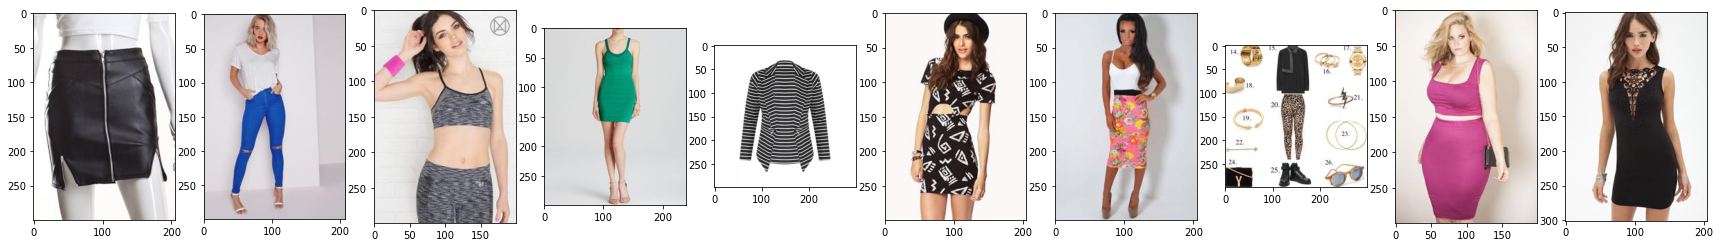

In [175]:
fig, axs = plt.subplots(1,10,figsize=(30,10))
for i in range(10):
    img_name_test = data_full[data_full[attr]==1].sample(1).iloc[0,0]
    full_path = PATH+img_name_test
    img = Image.open(full_path)
    axs[i].imshow(img)

In [456]:
drop = ['americana','angeles','art','athletic','audrey','babe','babydoll','barbie']

In [457]:
combine = [('abstract_chevron_print','abstract_chevron','abstract_diamond'),('abstract_floral','abstract_floral_print'),('abstract_geo','abstract_geo_print')]



In [458]:
columns = list(attribute_count.columns)

In [459]:
attr = 'abstract_pattern'